In [1]:
from bioinformatics import na_read as nr
#from bioinformatics import NCBIDataset as nds
from bioinformatics import FASTADataset as fads
from bioinformatics import KmerVectors as kvec

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
NGDC_PATH = "../data/bioinformatics/ngdc/"
IDOG_PATH = NGDC_PATH + "idog/"
#!ls -al $IDOG_PATH

In [3]:
dhole_cds_dataset_file = IDOG_PATH + "dhole.cds.fa"
wolfe_cds_dataset_file = IDOG_PATH + "wolf.cds.fa"
#!ls $dhole_cds_dataset_file
#!ls $wolfe_cds_dataset_file

In [4]:
dhole_cds_fads = fads.FASTADataset('dhole', dhole_cds_dataset_file)
wolfe_cds_fads = fads.FASTADataset('wolfe', wolfe_cds_dataset_file)

In [5]:
#dhole_cds_fads.fasta_dataset

In [6]:
#wolfe_cds_fads.fasta_dataset

In [7]:
kv_fasta = kvec.KmerVectors(['A','G','C','T'], 6, fastadatasets=[dhole_cds_fads,wolfe_cds_fads], verbose=True)
print(f'dictionary size: [{len(kv_fasta.dict)}]')
print(kv_fasta.labels)

KmerVectors Object -
alphabet [['A', 'G', 'C', 'T']]
dict: [['AAAAAA', 'AAAAAG', 'AAAAAC', 'AAAAAT']]...[['TTTTTA', 'TTTTTG', 'TTTTTC', 'TTTTTT']]
Labels: [{'dhole': 1, 'wolfe': 2}]
[dhole]
[../data/bioinformatics/ngdc/idog/dhole.cds.fa]
[wolfe]
[../data/bioinformatics/ngdc/idog/wolf.cds.fa]
dictionary size: [4096]
{'dhole': 1, 'wolfe': 2}


In [8]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [9]:
df_fasta = kv_fasta.seq2KmerSentences(seq_type='fna2', base_count_max=4, length_min=500, dataset_limit=1000, verbose=True)

FASTA Dataset
seq2KmerSentencesFASTA
fasta dataset: [dhole]
1000capped at [1000]
-
Total:                [1739]
Using :               [1001]
skip_count_minlength: [7]
skip_count_alphabet: [732]
fasta dataset: [wolfe]
1000capped at [1000]
-
Total:                [1859]
Using :               [1001]
skip_count_minlength: [28]
skip_count_alphabet: [831]


In [10]:
df_fasta=pd.DataFrame(data=df_fasta)
df_fasta

,v1,v2
0,dhole,ATGGCT TGGCTC GGCTCC GCTCCG CTCCGA TCCGAT CCGA...
1,dhole,ATGGCG TGGCGG GGCGGA GCGGAC CGGACG GGACGG GACG...
2,dhole,ATGGTT TGGTTT GGTTTT GTTTTT TTTTTA TTTTAT TTTA...
3,dhole,ATGCTG TGCTGT GCTGTC CTGTCG TGTCGA GTCGAG TCGA...
4,dhole,ATGAGC TGAGCG GAGCGT AGCGTC GCGTCC CGTCCC GTCC...
...,...,...
1995,wolfe,ATGAAG TGAAGA GAAGAT AAGATT AGATTC GATTCT ATTC...
1996,wolfe,ATGAAG TGAAGA GAAGAA AAGAAA AGAAAA GAAAAT AAAA...
1997,wolfe,ATGACA TGACAG GACAGA ACAGAA CAGAAA AGAAAA GAAA...
1998,wolfe,TGTGGC GTGGCC TGGCCT GGCCTT GCCTTC CCTTCC CTTC...


In [11]:
texts=df_fasta['v2']
texts

0       ATGGCT TGGCTC GGCTCC GCTCCG CTCCGA TCCGAT CCGA...
1       ATGGCG TGGCGG GGCGGA GCGGAC CGGACG GGACGG GACG...
2       ATGGTT TGGTTT GGTTTT GTTTTT TTTTTA TTTTAT TTTA...
3       ATGCTG TGCTGT GCTGTC CTGTCG TGTCGA GTCGAG TCGA...
4       ATGAGC TGAGCG GAGCGT AGCGTC GCGTCC CGTCCC GTCC...
                              ...                        
1995    ATGAAG TGAAGA GAAGAT AAGATT AGATTC GATTCT ATTC...
1996    ATGAAG TGAAGA GAAGAA AAGAAA AGAAAA GAAAAT AAAA...
1997    ATGACA TGACAG GACAGA ACAGAA CAGAAA AGAAAA GAAA...
1998    TGTGGC GTGGCC TGGCCT GGCCTT GCCTTC CCTTCC CTTC...
1999    ATGCTG TGCTGT GCTGTT CTGTTT TGTTTG GTTTGA TTTG...
Name: v2, Length: 2000, dtype: object

In [12]:
df=pd.DataFrame(data=df_fasta)
df = df_fasta.replace({"v1": kv_fasta.labels})

df

,v1,v2
0,1,ATGGCT TGGCTC GGCTCC GCTCCG CTCCGA TCCGAT CCGA...
1,1,ATGGCG TGGCGG GGCGGA GCGGAC CGGACG GGACGG GACG...
2,1,ATGGTT TGGTTT GGTTTT GTTTTT TTTTTA TTTTAT TTTA...
3,1,ATGCTG TGCTGT GCTGTC CTGTCG TGTCGA GTCGAG TCGA...
4,1,ATGAGC TGAGCG GAGCGT AGCGTC GCGTCC CGTCCC GTCC...
...,...,...
1995,2,ATGAAG TGAAGA GAAGAT AAGATT AGATTC GATTCT ATTC...
1996,2,ATGAAG TGAAGA GAAGAA AAGAAA AGAAAA GAAAAT AAAA...
1997,2,ATGACA TGACAG GACAGA ACAGAA CAGAAA AGAAAA GAAA...
1998,2,TGTGGC GTGGCC TGGCCT GGCCTT GCCTTC CCTTCC CTTC...


/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class distribution of Dhole(1) and Wolf(2)')

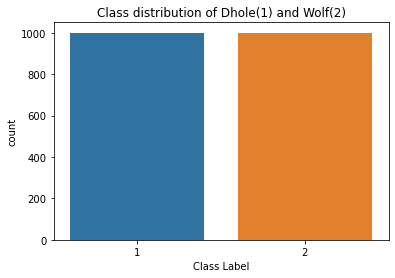

In [13]:
sns.countplot(df.v1)
plt.xlabel('Class Label')
plt.title('Class distribution of Dhole(1) and Wolf(2)')

In [14]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [16]:
print(f'X_train len: [{len(X_train)}]')
print(f'y_train len: [{len(Y_train)}]')

print(f'X_test len: [{len(X_test)}]')
print(f'y_test len: [{len(Y_test)}]')

X_train len: [1340]
y_train len: [1340]
X_test len: [660]
y_test len: [660]


In [17]:
Y_test

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
    

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [18]:
max_words = 100
#max_words = 1000
max_len = 1000
#max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

In [19]:
#tf.keras.layers.Embedding(
#    input_dim,
#    output_dim,
#    embeddings_initializer="uniform",
#    embeddings_regularizer=None,
#    activity_regularizer=None,
#    embeddings_constraint=None,
#    mask_zero=False,
#    input_length=None,
#    **kwargs
#)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
#    layer = Embedding(max_words,5000,input_length=max_len)(inputs)
    layer = Embedding(max_words,5000,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [20]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer="Adam",metrics=['accuracy'])

2022-10-02 15:16:04.655637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 5000)        500000    
                                                                 
 lstm (LSTM)                 (None, 64)                1296640   
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss')])
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.4,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[])

Epoch 1/10


2022-10-02 15:16:07.152626: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2560000000 exceeds 10% of free system memory.
2022-10-02 15:16:07.698080: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2560000000 exceeds 10% of free system memory.
2022-10-02 15:16:20.990747: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2560000000 exceeds 10% of free system memory.
2022-10-02 15:16:24.848931: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2560000000 exceeds 10% of free system memory.


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()